In [1]:
import pandas as pd, psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def query_database(connection, sql, *args, **kwargs):
    if connection.get_transaction_status() == 3:
        connection.reset()
    with connection.cursor() as cursor:
        cursor.execute(sql, *args, **kwargs)
        rows = cursor.fetchall()
        columns = [d[0] for d in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [3]:
connection = psycopg2.connect('postgres://fga@localhost/fga')

In [21]:
sql = '''
with devices_ as (
    select
        "Id" as device_id,
        "DeviceOS" as client,
        "UserID" as user_id
        
    from devices
    
), events_ as (
    select
        "createdAt"::timestamp as ts,
        "DeviceOS" as client,
        "currentUser" as user_id,
        "action" as action
        
    from events 
        join devices on "currentUser" = "UserID"

), active_users as (
    select distinct
        ts::date as date,
        client,
        user_id
        
    from events_
    
), quiz_players as (
    select distinct
        ts::date as date,
        client,
        user_id
        
    from events_
    
    where action = 'START_QUIZ'
    
), user_segmentation as (
    select
        date,
        client,
        user_id,
        case 
            when quiz_players.user_id is null then false
            else true
        end as did_play_quiz
        
    from active_users
        left join quiz_players using (date, client, user_id)
        
), sessions_ as (
    select
        device_id,
        did_play_quiz,
        devices_.client,
        session_start,
        session_end,
        session_id,
        session_end - session_start as session_length
        
    from sessions join devices_ using (device_id)
        join user_segmentation on (
                devices_.user_id = user_segmentation.user_id
                and devices_.client = user_segmentation.client
                and sessions.session_start::date = user_segmentation.date
            )
        
), results_mean as (
    select
        session_start::date as date,
        client,
        did_play_quiz,
        avg(session_length) as mean_session_length
        
    from sessions_
    
    group by 1, 2, 3
    
    order by 1, 2, 3
    
), results_median as (
    select 
        session_start::date as date,
        client,
        did_play_quiz,
        percentile_disc(0.5) within group (order by session_length) as median_session_length
    
    from sessions_
    
    group by 1, 2, 3
    
    order by 1, 2, 3
    
), results as (
    select * from results_mean join results_median using (date, client, did_play_quiz)
)

select * from results

'''

df = query_database(connection, sql)
df.head()

,date,client,did_play_quiz,mean_session_length,median_session_length
0,2019-10-14,Android,False,00:02:10.350082,00:00:39.015856
1,2019-10-14,Android,True,00:04:20.053202,00:02:31.329019
2,2019-10-14,iOS,False,00:01:26.489059,00:00:34.640811
3,2019-10-14,iOS,True,00:03:51.874444,00:01:56.047500
4,2019-10-15,Android,False,00:01:54.646093,00:00:48.437789


In [24]:
df['mean_session_length'] = df['mean_session_length'].dt.seconds / 60
df['median_session_length'] = df['median_session_length'].dt.seconds / 60

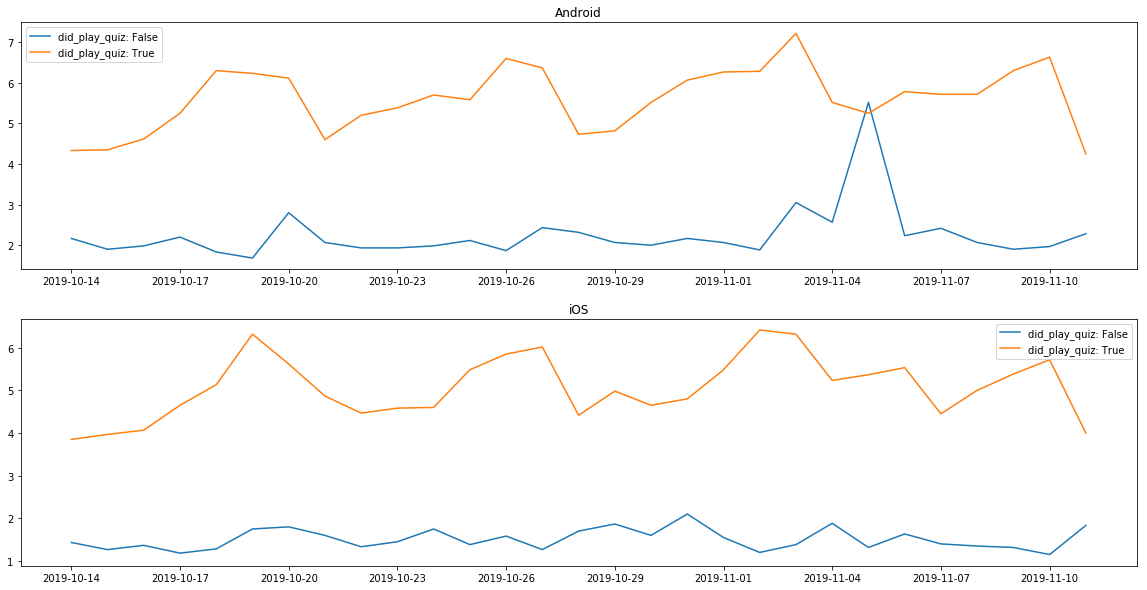

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

for i, (client, df_) in enumerate(df.groupby('client')):
    ax = axes[i]
    for did_play_quiz, df__ in df_.groupby('did_play_quiz'):
        ax.plot(df__['date'], df__['mean_session_length'], label=f'did_play_quiz: {did_play_quiz}')
    ax.legend()
    ax.set_title(client)

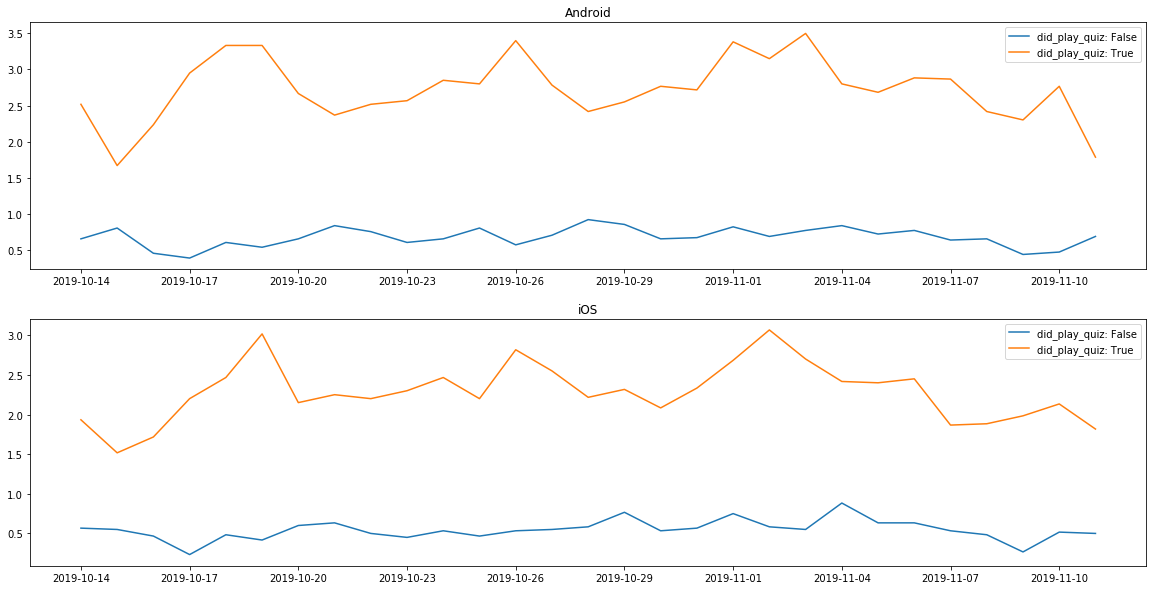

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

for i, (client, df_) in enumerate(df.groupby('client')):
    ax = axes[i]
    for did_play_quiz, df__ in df_.groupby('did_play_quiz'):
        ax.plot(df__['date'], df__['median_session_length'], label=f'did_play_quiz: {did_play_quiz}')
    ax.legend()
    ax.set_title(client)